In [1]:
# Algorithm:
# read the position and velocity data
# sort position data by Z-position

# For Longitudinal acoustic mode, use LA mode frequency from dispersion relation
# Calculate and add displacement in z-direction and velocity in the z-direction as well

# For Transverse acoustic mode along x-dirn, use TAx mode frequency from dispersion relation
# Calculate and add displacement in x-direction and velocity in the x-direction as well

# Remember the structure file produced will have atom id in floating point, put it into ovito
# save as atomic full style, then it will correct it. Just a final work around. But it will
# make all velocity values zero, so copy it from the original file created from here.

In [2]:
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cmath

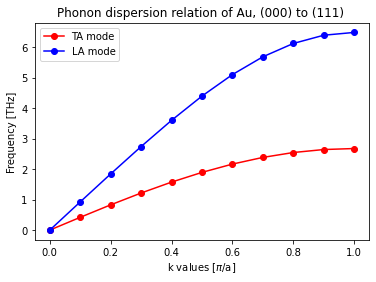

In [3]:
# Phonon dispersion relation values:
# Along 000 ==> 111 direction
LA_freq = np.array([0.00,925461626247.93,1843126160310.45,2741039078132.37,3600698718147.45,
                    4397269403736.85,5102035424373.30,5685976180599.75,6123273156203.04,
                    6393976302314.61,6485618869485.52])

TA_freq = np.array([0.00,419656228038.71,828716471524.88,1216957807640.71,1574837572634.86,
                    1893702257207.15,2165911021001.29,2384922632417.69,2545398447322.77,
                    2643344720528.80,2676275393098.56])

TA_freq_THz = TA_freq/1e12; 
LA_freq_THz = LA_freq/1e12;

k_val = np.arange(0.0, 1.1, 0.1); k_val[4]

plt.plot(k_val, TA_freq_THz, 'o-r', label='TA mode')
plt.plot(k_val, LA_freq_THz, 'o-b', label='LA mode')
plt.xlabel('k values [$\pi$/a]')
plt.ylabel('Frequency [THz]')
plt.title('Phonon dispersion relation of Au, (000) to (111) ')
plt.legend()
plt.show()


In [4]:
# Input variables:
a0 = 4.07901835             # lattice parameter of Au
A = 0.002             # Amplitude of the wave in angstrom, 2e-3
eps_k0 = 1             # e(k0) = Polarization wave vector, why 1?
gamma = 50*a0           # Spatial extent
val = 4

a = a0                      # Case-1     
# a = a0*np.sqrt(3)              # Case-2
# a = a0/np.sqrt(3)              # Case-3

k0 = k_val[val]*np.pi/a  # wave vector, k0 = 0.9*pi/a

w_LA = 2*np.pi*LA_freq[val]           # in Hz, LA freq corresponding to k0 = 0.9*pi/a
w_TA = 2*np.pi*TA_freq[val]           # in Hz, TA freq corresponding to k0 = 0.9*pi/a

# Structural variable:
N_atoms = 358560  # Number of atoms
N_layer = 996     # Number of Au(111) layers
N_layeratom = 360 # Number of atoms in each Au(111) layer N_atoms/N_layer

print("LA freq:", LA_freq_THz[val],"THz", "TA freq: ", TA_freq_THz[val], "THz")

LA freq: 3.61199517290495 THz TA freq:  1.58394782478052 THz


In [5]:
offset_p = 19
N_atoms = 358560

print("Original position: data.npt50psaurelax_EM")
with open("data_cg_boxrelax.npt50psaurelax_EM", "r") as file:
    lines = file.readlines()

# Read position data:
plines = lines[offset_p:(N_atoms+offset_p)]
# Extract data from line 19 to 358579
position = np.array([list(map(float, line.strip().split())) for line in plines])
print("Shape of position:", position.shape)

# Read velocity data:
offset_v = N_atoms+offset_p + 3
vlines = lines[offset_v:(N_atoms+offset_v)]
# Extract data from line 19 to 358579
velocity = np.array([list(map(float, line.strip().split())) for line in vlines])
print("Shape of velocity:", velocity.shape)

Original position: data.npt50psaurelax_EM
Shape of position: (358560, 10)
Shape of velocity: (358560, 4)


In [6]:
# Sorting the position according to Z-position:
sorted_index = np.argsort(position[:, 6])
position = position[sorted_index]            # col 4 = x, col 5 = y, col 6 = z

# Sorting the velocity according to atomid:
v_index = np.argsort(velocity[:, 0])
velocity = velocity[v_index]; 

2340.6464846223594
-2.6007416136501784


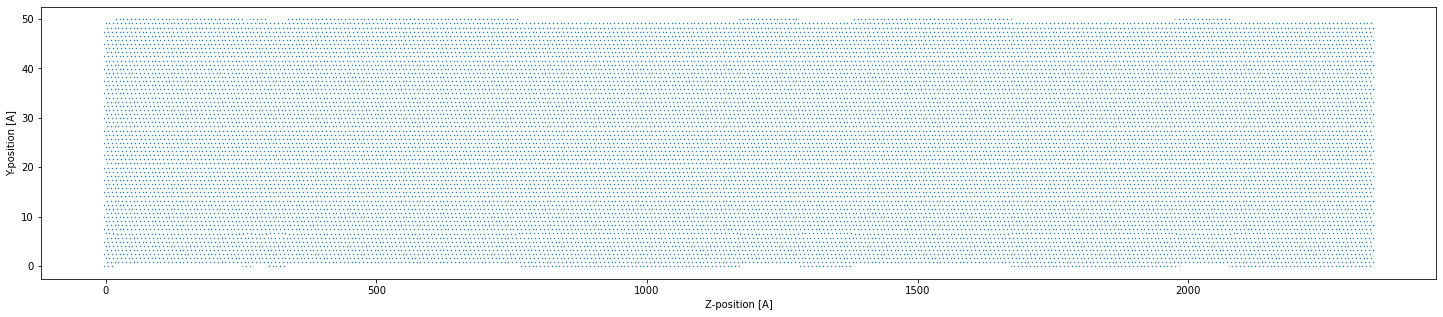

In [7]:
maxZ = np.max(position[:, 6]); print(maxZ)
minZ = np.min(position[:, 6]); print(minZ)

# position[:, 6] = position[:, 6] - minZ       # shifting the lower limit to zero

plt.figure(figsize =(25, 5))
plt.plot(position[:, 6], position[:, 5], '.', markersize=0.1)
plt.xlabel('Z-position [A]')
plt.ylabel('Y-position [A]')
plt.show()

In [8]:
N_layers = position.shape[0] // N_layeratom   # Number of Au layers

# initialize the new array
Au_layers = np.zeros((N_layers, 1)) # Creating empty array

# loop over the number of averages
for i in range(N_layers):
    start = i * N_layeratom
    end = (i + 1) * N_layeratom
    
    # calculate the average of every 360 rows
    avg = np.mean(position[start:end, 6], axis=0)
    
    # store the average in the new array
    Au_layers[i, 0] = avg
Au_layers = Au_layers.reshape(-1)         

In [9]:
# Computing the displacements
xn = Au_layers                             # All positions
x0 = Au_layers[Au_layers.shape[0]//2]      # middle of the Au layer, for 2600 A

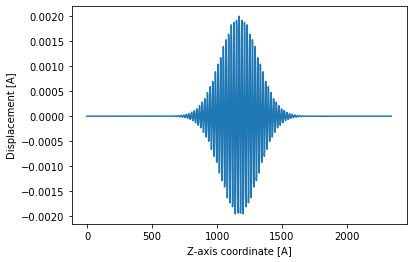

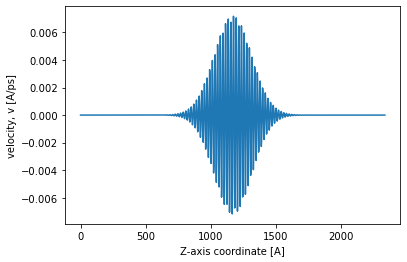

In [16]:
y = 0 + k0*(xn - x0)*1j
disp = A*eps_k0*np.exp(-(xn - x0)**2/gamma**2)*np.exp(y)

# Plot the position
U = np.real(disp)                        # Take the real part for displacement
plt.plot(xn, U)
plt.xlabel("Z-axis coordinate [A]")
plt.ylabel("Displacement [A]")
plt.savefig("Wave-packet_displacement.png", dpi= 200, bbox_inches = 'tight', facecolor="w")
# plt.xlim(800, 900)
# plt.ylim(-0.2, 0.2)
plt.show()

np.savetxt("Wave-packet_displacement.dat", U)

# Plot the velocity
vel = (w_LA*np.imag(disp))/1e12           # For LA mode set this as velocity in z-dirn, A/ps            
plt.plot(xn, vel)
plt.xlabel("Z-axis coordinate [A]")
plt.ylabel("velocity, v [A/ps]")
plt.savefig("Wave-packet_velocity.png", dpi= 200, bbox_inches = 'tight', facecolor="w")
# plt.xlim(500, 550)
# plt.ylim(-0.5, 0.5)
plt.show()

np.savetxt("Wave-packet_velocity.dat", vel)

In [11]:
# Repeating each of these values 360 times for all the atoms in each Au layer
new_pos = (U.reshape(U.shape[0], 1) @ np.ones(N_layeratom).reshape(1, N_layeratom)).flatten()
new_vel = (vel.reshape(vel.shape[0], 1) @ np.ones(N_layeratom).reshape(1, N_layeratom)).flatten()

In [12]:
# Now let's do the replacement of both position and velocity:

# position
# Adding displacement to the Z-position 
# new_z = position[:, 6] + new_pos
position[:, 6] = 1.0000000000*new_pos + 1.0000000000*position[:, 6]

phonon_pos = position[:, 0:7]                     # only taking from 0 to 6th column
p_index = np.argsort(phonon_pos[:, 0])
phonon_pos = phonon_pos[p_index]

# velocity
# replacing vz component of velocity, vx = vy = 0 A/ps for LA mode
velocity[:, 0] = position[:, 0]                 # atom ids
velocity[:, 1] = np.zeros(velocity.shape[0])    # vx = 0 A/ps
velocity[:, 2] = np.zeros(velocity.shape[0])    # vy = 0 A/ps
velocity[:, 3] = 1.0000000000*new_vel           # vz = computed velocity

# Sorting the velocity according to atomid:
v_index = np.argsort(velocity[:, 0])
velocity = velocity[v_index];
# velocity = np.abs(velocity[v_index]); 

In [13]:
# os.system('rm Au_111_18x10x332*.lmp')

with open("Au_111_18x10x332_LA_A002_k2.lmp", "w") as output_file:
    for i in range(0, 19):
        output_file.write(lines[i])
    
    for item in phonon_pos:
        item_arr = " ".join(str(elem) for elem in item)
        output_file.write(item_arr + "\n")
    
    output_file.write("\n")
    output_file.write("Velocities"+ "\n")
    output_file.write("\n")
    
    for item in velocity:
        item_arr = " ".join(str(elem) for elem in item)
        output_file.write(item_arr + "\n")

In [14]:
# Sorting the position according to Z-position:
sorted_index = np.argsort(position[:, 0])
position = position[sorted_index]            # col 4 = x, col 5 = y, col 6 = z
np.savetxt("Original_z_position.dat", position[:, 6])